In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

print(tf.__version__) 
print("x")


2.8.0
x


C:\Users\Shreedhar\AppData\Local\Temp\ipykernel_13364\2867826293.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [3]:
TRAINING_FILE = "C:/Users/Shreedhar/Desktop/FINAL YEAR PROJECT/aslflutter/ASL-Python/sign_mnist_train/sign_mnist_train.csv"
VALIDATION_FILE = "C:/Users/Shreedhar/Desktop/FINAL YEAR PROJECT/aslflutter/ASL-Python/sign_mnist_test/sign_mnist_test.csv"

In [4]:
train_data = pd.read_csv(TRAINING_FILE)
print(train_data.shape)
train_data.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
test_data = pd.read_csv(VALIDATION_FILE)
print(test_data.shape)
test_data.head()

(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [6]:
y_train = train_data['label']
y_test = test_data['label']
del train_data['label']
del test_data['label']

In [7]:
unique_labels = y_train.unique()
unique_labels = np.sort(unique_labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

c:\users\shreedhar\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


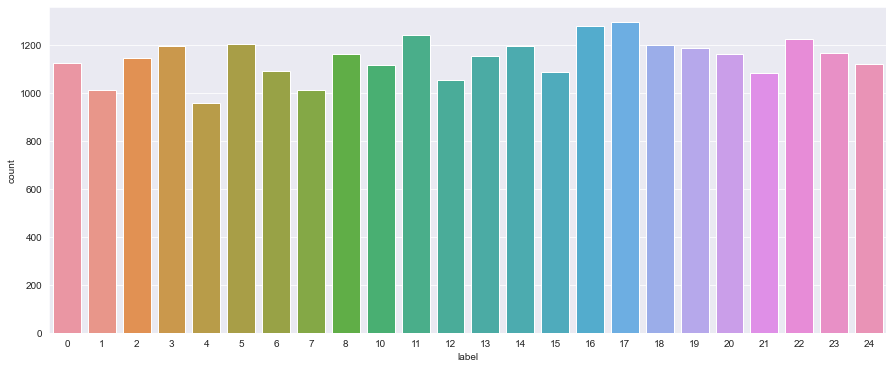

In [25]:
# visulaizing the data
plt.figure(figsize=(15,6))
sns.set_style("darkgrid");
sns.countplot(y_train);

In [115]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

y_train[:2]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]], dtype=int32)

In [8]:
def preprocess_image(x):
    
    
    x = x/255
    x = x.reshape(-1,28,28,1) # convertin it into 28 x 28 gray scaled image
    
    return x

In [9]:
train_x = preprocess_image(train_data.values)
test_x = preprocess_image(test_data.values)

In [100]:
def show_images(images,labels):
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            ax[i,j].imshow(images[k] , cmap='gray')
            ax[i,j].set_title(str(unique_labels[np.argmax(y_train[k])]))
            k = k+1;
    plt.tight_layout()

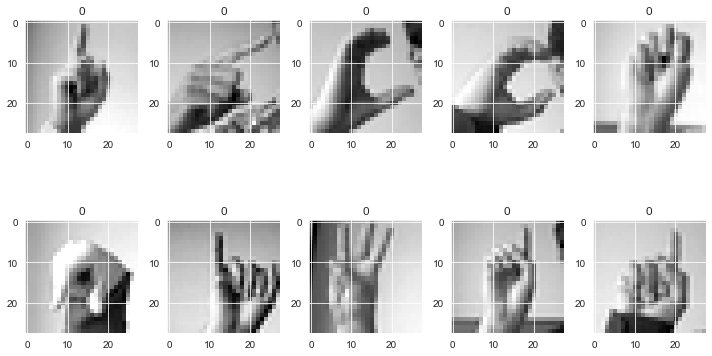

In [144]:
show_images(train_x,y_train)

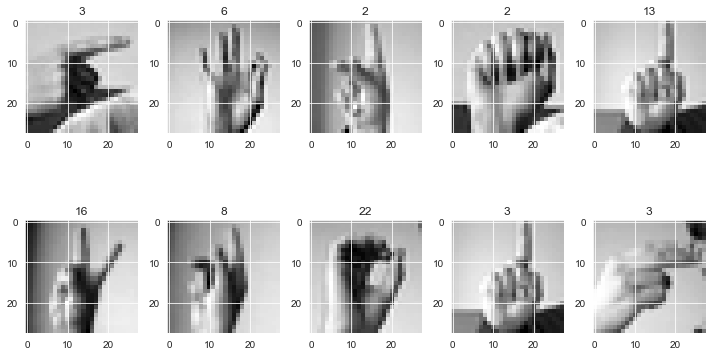

In [31]:
#let's visualize test images as well
show_images(test_x,y_test)

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_x)

In [40]:

def build_model(hp):  
    model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=75, max_value=200, step=25),
        kernel_size=(3,3),
        activation='relu',
        
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=50, max_value=125, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    
    keras.layers.Dropout(
        rate = hp.Choice('drop_1_rate', values = [0.1,0.5])
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    
    
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=25, max_value=75, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),  
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=32),
        activation='relu'
    ),
    keras.layers.Dropout(
        rate = hp.Choice('drop_2_rate', values = [0.1,0.3])
    ),
    keras.layers.Dense(24, activation='softmax')
  ])
  
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
    return model
  

In [41]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="ASLdetection1")

In [42]:
tuner_search.search(train_x,y_train,epochs=5,validation_data = (test_x, y_test))

Trial 3 Complete [00h 03m 28s]
val_accuracy: 0.9181539416313171

Best val_accuracy So Far: 0.948968231678009
Total elapsed time: 00h 10m 35s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
175               |125               |conv_1_filter
100               |75                |conv_2_filter
0.1               |0.5               |drop_1_rate
75                |50                |conv_3_filter
768               |864               |dense_1_units
0.1               |0.1               |drop_2_rate
0.01              |0.001             |learning_rate

Epoch 1/5
312/858 [=========>....................] - ETA: 41s - loss: 1.0439 - accuracy: 0.7177

KeyboardInterrupt: 

In [43]:
model=tuner_search.get_best_models(num_models=1)[0]

In [44]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.00001)

In [45]:
history = model.fit(datagen.flow(train_x,y_train, batch_size = 128) 
                    ,epochs = 2
                    , validation_data = (test_x, y_test)
                    , callbacks = [lr_reduction])

Epoch 1/2
215/215 [==============================] - 46s 213ms/step - loss: 0.1866 - accuracy: 0.9453 - val_loss: 0.0341 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 2/2
215/215 [==============================] - 44s 205ms/step - loss: 0.0604 - accuracy: 0.9799 - val_loss: 0.0560 - val_accuracy: 0.9817 - lr: 0.0010


In [46]:
predictions = model.predict(test_x)

In [12]:
print(predictions)

NameError: name 'predictions' is not defined

In [11]:
def predictions_to_labels(pred):
    labels =[]
    for p in pred:
        labels.append(unique_labels[np.argmax(p)])
    return labels

In [49]:
y_pred_labels = predictions_to_labels(predictions)
y_test_labels = predictions_to_labels(y_test)

In [17]:
accuracy_score(y_test_labels,y_pred_labels)

0.04559397657557167

In [135]:
print(y_pred_labels[19])

7


In [134]:
print(y_test_labels[18])

0


In [90]:
model.save("AslModel-2.h5")

In [13]:
modelx = tf.keras.models.load_model('Aslmodel-2.h5')

In [15]:
predictions = modelx.predict(test_x)

In [16]:
print(modelx)
y_pred_labels = predictions_to_labels(predictions)
y_test_labels = predictions_to_labels(y_test)
accuracy_score(y_test_labels,y_pred_labels)

0.04559397657557167

In [18]:
print(y_pred_labels[0])
print(y_test_labels[0])

6
0


In [19]:
print(predictions)

[[2.1752533e-09 7.5041839e-09 3.2998043e-06 ... 1.5053806e-09
  4.1102107e-06 1.4443876e-08]
 [3.8645635e-11 2.3475422e-07 1.5674156e-12 ... 4.9437108e-07
  2.7689058e-14 1.5239163e-08]
 [2.5006898e-12 1.1727354e-13 1.2095907e-13 ... 8.5987164e-12
  2.3351820e-10 3.7851753e-09]
 ...
 [1.0783212e-09 1.1778512e-11 9.9999726e-01 ... 1.5822468e-12
  2.2999822e-09 9.2616149e-12]
 [2.8770449e-04 9.3646651e-07 9.1587839e-07 ... 1.5897148e-09
  1.1213163e-07 1.6853921e-08]
 [4.6445567e-10 2.9328100e-12 9.9999738e-01 ... 8.8117892e-13
  6.2073091e-10 1.7954120e-12]]
